# IMPORT DEPENDENCIES

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import RandomOverSampler
import time
import shutil
import pathlib
import itertools
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
import warnings
from tensorflow.keras.preprocessing.image import ImageDataGenerator

warnings.filterwarnings("ignore")

# DATA PREPARATION

In [2]:
!unzip Dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: Knee_Osteoarthritis_Classification/test/Osteoporosis/Osteoporosis 724_aug_0.jpeg  
  inflating: Knee_Osteoarthritis_Classification/test/Osteoporosis/Osteoporosis 725.jpg  
  inflating: Knee_Osteoarthritis_Classification/test/Osteoporosis/Osteoporosis 725_aug_0.jpeg  
  inflating: Knee_Osteoarthritis_Classification/test/Osteoporosis/Osteoporosis 726.jpg  
  inflating: Knee_Osteoarthritis_Classification/test/Osteoporosis/Osteoporosis 726_aug_0.jpeg  
  inflating: Knee_Osteoarthritis_Classification/test/Osteoporosis/Osteoporosis 727.jpg  
  inflating: Knee_Osteoarthritis_Classification/test/Osteoporosis/Osteoporosis 727_aug_0.jpeg  
  inflating: Knee_Osteoarthritis_Classification/test/Osteoporosis/Osteoporosis 728.jpg  
  inflating: Knee_Osteoarthritis_Classification/test/Osteoporosis/Osteoporosis 728_aug_0.jpeg  
  inflating: Knee_Osteoarthritis_Classification/test/Osteoporosis/Osteoporosis 729.jpg  
  inflating: Knee_Osteoa

In [3]:
dataPath = 'Dataset/'
categories = ["Normal","Osteopenia", "Osteoporosis"]

In [4]:
imagePaths = []
labels = []

for category in categories:
    category_path = os.path.join(dataPath, "train", category)
    for image_name in os.listdir(category_path):
        image_path = os.path.join(category_path, image_name)
        imagePaths.append(image_path)
        labels.append(category)

len(imagePaths), len(labels)

(3780, 3780)

In [5]:
df = pd.DataFrame({"image_path": imagePaths, "label": labels})
print(df.shape)

(3780, 2)


In [6]:
print(df.duplicated().sum())
print(df.isnull().sum())
print(df.info())
print("Unique labels: {}".format(df['label'].unique()))
print("Label counts: {}".format(df['label'].value_counts()))

0
image_path    0
label         0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3780 entries, 0 to 3779
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  3780 non-null   object
 1   label       3780 non-null   object
dtypes: object(2)
memory usage: 59.2+ KB
None
Unique labels: ['Normal' 'Osteopenia' 'Osteoporosis']
Label counts: label
Normal          1260
Osteopenia      1260
Osteoporosis    1260
Name: count, dtype: int64


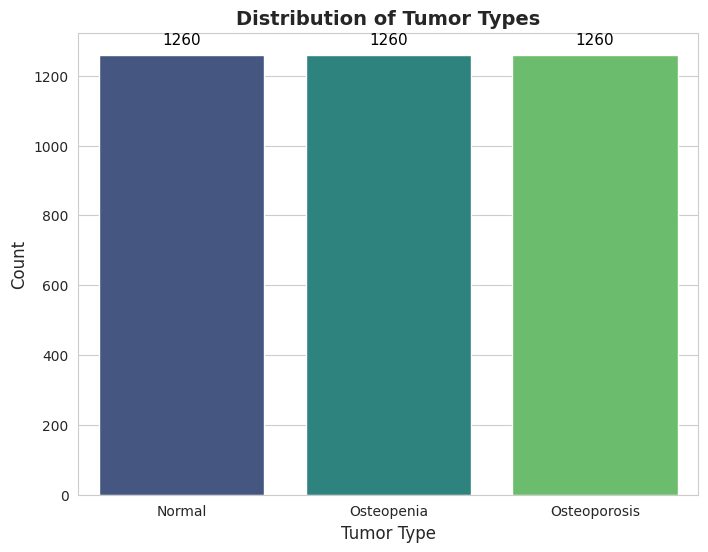

In [7]:
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(8, 6))
sns.countplot(data=df, x="label", palette="viridis", ax=ax)
ax.set_title("Distribution of Tumor Types", fontsize=14, fontweight='bold')
ax.set_xlabel("Tumor Type", fontsize=12)
ax.set_ylabel("Count", fontsize=12)
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center', va='bottom', fontsize=11, color='black',
        xytext=(0, 5), textcoords='offset points')

Text(0.5, 1.0, 'Distribution of Tumor Types - Pie Chart')

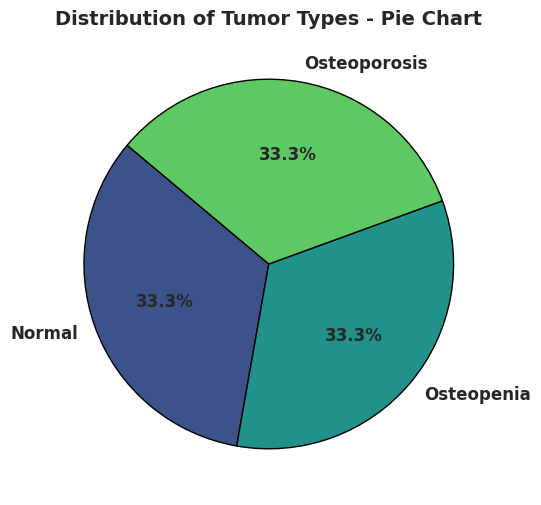

In [8]:
label_counts = df["label"].value_counts()
fig, ax = plt.subplots(figsize=(8, 6))
colors = sns.color_palette("viridis", len(label_counts))
ax.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%',
startangle=140, colors=colors, textprops={'fontsize': 12, 'weight':
'bold'},
wedgeprops={'edgecolor': 'black', 'linewidth': 1})
ax.set_title("Distribution of Tumor Types - Pie Chart", fontsize=14,
fontweight='bold')

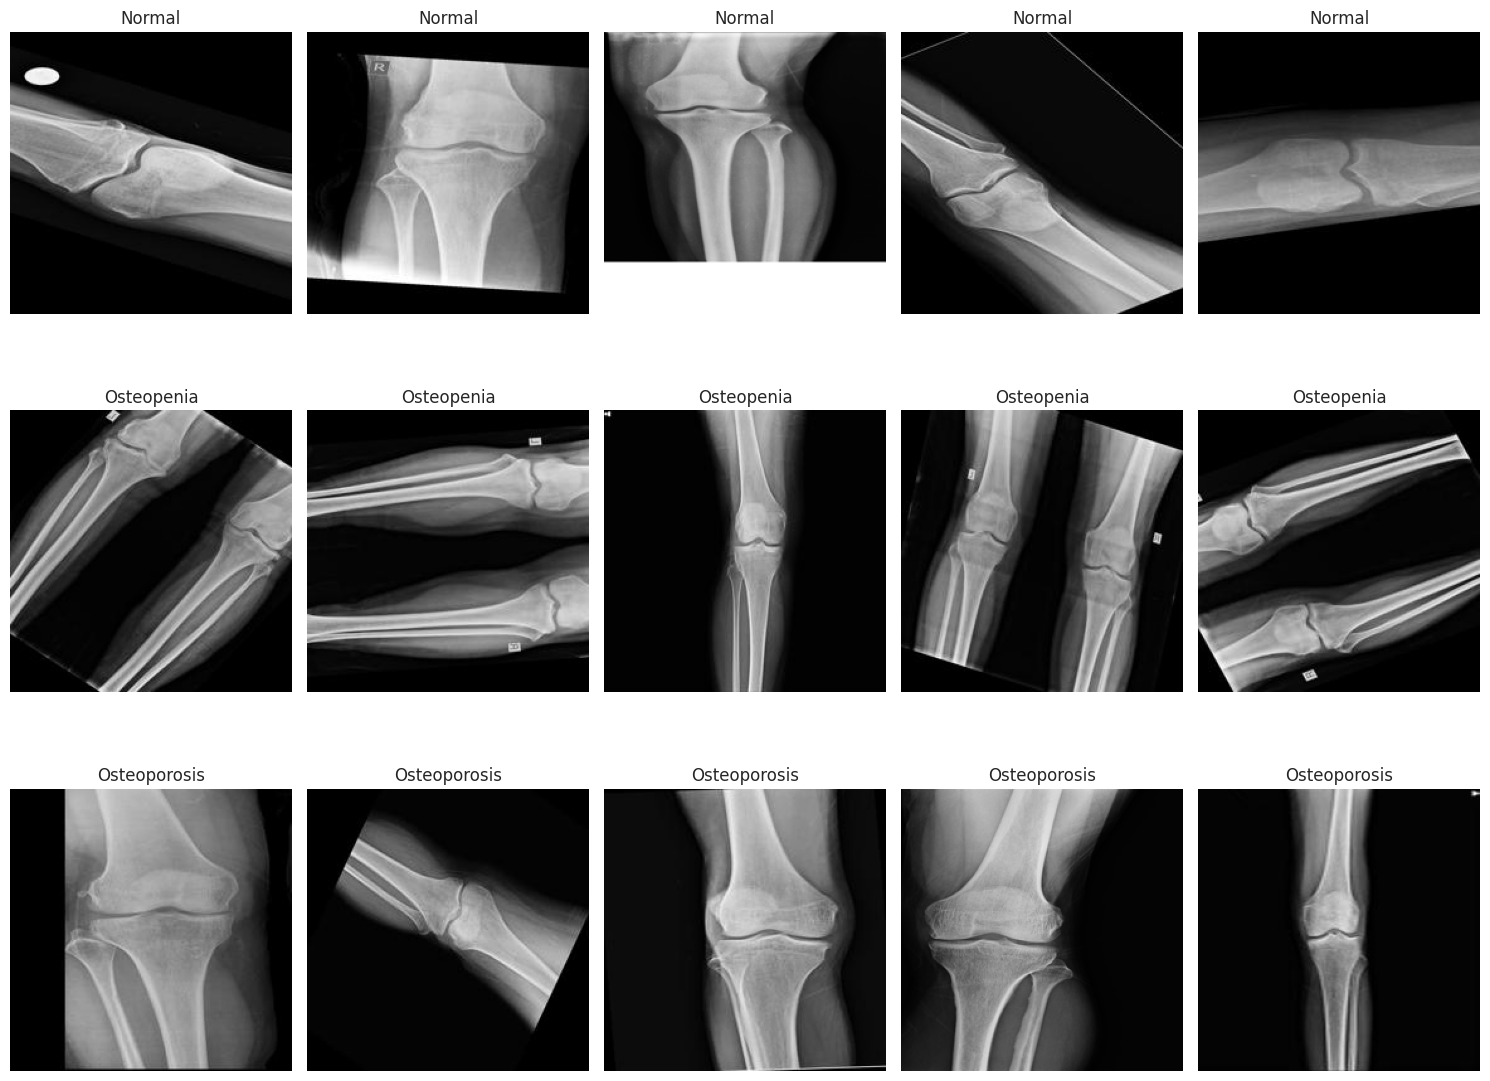

In [9]:
num_images = 5
plt.figure(figsize=(15, 12))
for i, category in enumerate(categories):
    category_images = df[df['label'] == category]['image_path'].iloc[:num_images]
    for j, img_path in enumerate(category_images):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(len(categories), num_images, i * num_images + j + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(category)

plt.tight_layout()
plt.show(block=False)
plt.pause(5)
plt.close()


In [10]:
label_encoder = LabelEncoder()
df['category_encoded'] = label_encoder.fit_transform(df['label'])
df = df[['image_path', 'category_encoded']]

In [11]:
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(df[['image_path']], df['category_encoded'])
df_resampled = pd.DataFrame(X_resampled, columns=['image_path'])
df_resampled['category_encoded'] = y_resampled
print("\nClass distribution after oversampling:")
print(df_resampled['category_encoded'].value_counts())
print(df_resampled)


Class distribution after oversampling:
category_encoded
0    1260
1    1260
2    1260
Name: count, dtype: int64
                                             image_path  category_encoded
0            Dataset/train/Normal/Normal 240_aug_0.jpeg                 0
1             Dataset/train/Normal/Normal 87_aug_0.jpeg                 0
2                   Dataset/train/Normal/Normal 325.png                 0
3             Dataset/train/Normal/Normal 66_aug_0.jpeg                 0
4              Dataset/train/Normal/Normal 1_aug_0.jpeg                 0
...                                                 ...               ...
3775  Dataset/train/Osteoporosis/Osteoporosis 282_au...                 2
3776     Dataset/train/Osteoporosis/Osteoporosis 22.png                 2
3777    Dataset/train/Osteoporosis/Osteoporosis 190.png                 2
3778                Dataset/train/Osteoporosis/OS4.JPEG                 2
3779         Dataset/train/Osteoporosis/OS28_aug_3.jpeg                 2

In [12]:
df_resampled['category_encoded'] = df_resampled['category_encoded'].astype(str)

In [13]:
train_df_new, temp_df_new = train_test_split(
df_resampled,
train_size=0.8,
shuffle=True,
random_state=42,
stratify=df_resampled['category_encoded']
)
print(train_df_new.shape)
print(temp_df_new.shape)

(3024, 2)
(756, 2)


In [14]:
valid_df_new, test_df_new = train_test_split(
temp_df_new,
test_size=0.5,
shuffle=True,
random_state=42,
stratify=temp_df_new['category_encoded']
)
print(valid_df_new.shape)
print(test_df_new.shape)

(378, 2)
(378, 2)


In [15]:
batch_size = 16
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

In [16]:
tr_gen = ImageDataGenerator(rescale=1./255)
ts_gen = ImageDataGenerator(rescale=1./255)

In [17]:
train_gen_new = tr_gen.flow_from_dataframe(
train_df_new,
x_col='image_path',
y_col='category_encoded',
target_size=img_size,
class_mode='sparse',
color_mode='rgb',
shuffle=True,
batch_size=batch_size
)

Found 3024 validated image filenames belonging to 3 classes.


In [18]:
valid_gen_new = ts_gen.flow_from_dataframe(
valid_df_new,
x_col='image_path',
y_col='category_encoded',
target_size=img_size,
class_mode='sparse',
color_mode='rgb',
shuffle=True,
batch_size=batch_size
)

Found 378 validated image filenames belonging to 3 classes.


In [19]:
test_gen_new = ts_gen.flow_from_dataframe(
test_df_new,x_col='image_path',
y_col='category_encoded',
target_size=img_size,
class_mode='sparse',
color_mode='rgb',
shuffle=False,
batch_size=batch_size
)

Found 378 validated image filenames belonging to 3 classes.


# Weights and Bias

In [20]:
%pip install wandb -q

In [21]:
!wandb login

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: rawanbekheet (csen-240) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [22]:
import wandb

In [23]:
from wandb.integration.keras import WandbMetricsLogger

# MobileNet

In [38]:
def create_mobilenet_model(input_shape, num_classes=3, learning_rate=1e-4):
    inputs = tf.keras.layers.Input(shape=input_shape, name='input_layer')
    base_model = tf.keras.applications.MobileNetV2(classes=3, input_tensor=inputs, weights="imagenet", name='MobileNet', include_top=False)
    base_model.trainable = False
    x = base_model.output
    x = tf.keras.layers.GlobalAveragePooling2D(name='global_avg_pooling')(x)
    x = tf.keras.layers.BatchNormalization(name='batch_normalization')(x)
    x = tf.keras.layers.Dropout(0.25, name='dropout')(x)
    x = tf.keras.layers.Dense(1024, activation='relu', name='dense_layer')(x)
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax', name='output_layer')(x)
    model = tf.keras.models.Model(inputs=inputs, outputs=outputs, name='MobileNet')
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# TRAINING

In [39]:
input_shape = (224, 224, 3)
cnn_model = create_mobilenet_model(input_shape)

In [40]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5,
restore_best_weights=True)

In [41]:
wandb.init(
    entity='csen-240',
    project='CSEN-240-ML-Project'
)
history = cnn_model.fit( train_gen_new,
                         validation_data=valid_gen_new,
                         epochs=250,
                         callbacks=[early_stopping, WandbMetricsLogger()],
                         verbose=1)
wandb.finish()

Epoch 1/250
189/189 ━━━━━━━━━━━━━━━━━━━━ 24s 60ms/step - accuracy: 0.5444 - loss: 1.0258 - val_accuracy: 0.6746 - val_loss: 0.6967
Epoch 2/250
189/189 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.6980 - loss: 0.7092 - val_accuracy: 0.7328 - val_loss: 0.6377
Epoch 3/250
189/189 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.7650 - loss: 0.5891 - val_accuracy: 0.7487 - val_loss: 0.5855
Epoch 4/250
189/189 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.7601 - loss: 0.5566 - val_accuracy: 0.7381 - val_loss: 0.6063
Epoch 5/250
189/189 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.7919 - loss: 0.4646 - val_accuracy: 0.7672 - val_loss: 0.5817
Epoch 6/250
189/189 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - accuracy: 0.8224 - loss: 0.4452 - val_accuracy: 0.7407 - val_loss: 0.6004
Epoch 7/250
189/189 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.8308 - loss: 0.4179 - val_accuracy: 0.7513 - val_loss: 0.5812
Epoch 8/250
189/189 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step - accuracy: 0.8483 - loss: 0.3826 -

epoch/accuracy,▁▃▄▅▅▆▆▆▇▇▇▇▇████
epoch/epoch,▁▁▂▂▃▃▄▄▅▅▅▆▆▇▇██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▆▅▄▄▃▃▃▂▂▂▂▂▁▁▁▁
epoch/val_accuracy,▁▅▆▅▇▅▆▆▆▅▇██▇▆█▇
epoch/val_loss,█▅▂▃▂▃▂▂▃▂▂▁▂▄▄▂▄
epoch/accuracy,0.91104
epoch/epoch,16
epoch/learning_rate,0.0001
epoch/loss,0.25217
epoch/val_accuracy,0.76455


In [ ]:
wandb.finish()

epoch/accuracy,▁▂▃▄▄▄▅▅▆▆▆▆▇▇▇▇▇▇██████
epoch/epoch,▁▁▂▂▂▃▃▃▃▄▄▄▅▅▅▆▆▆▆▇▇▇██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▇▆▆▅▅▄▄▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁
epoch/val_accuracy,▅▁▅▁▅▆▇▇▄▆▇▄▇██▇█▅█▇█▇▆█
epoch/val_loss,▃▅▁█▁▂▁▂▅▃▁█▂▂▂▃▂▄▂▃▃▃▃▆
epoch/accuracy,0.93254
epoch/epoch,23
epoch/learning_rate,0.0001
epoch/loss,0.19775
epoch/val_accuracy,0.73545


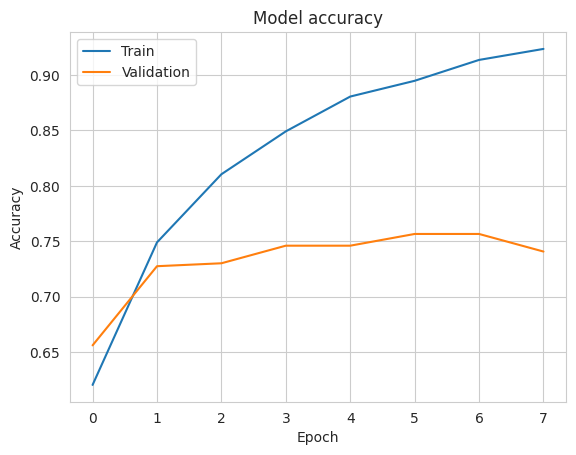

In [28]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

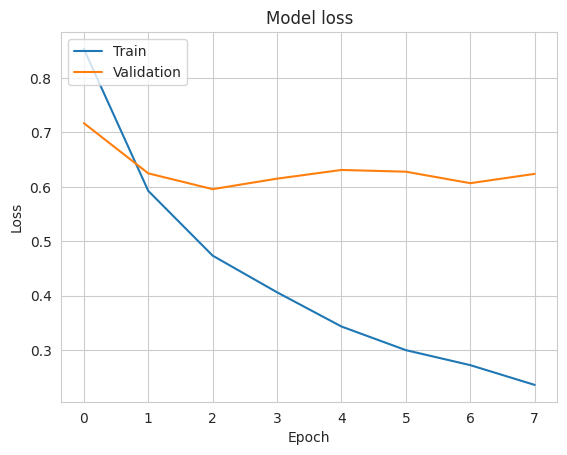

In [29]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

In [42]:
train_labels = train_gen_new.classes
predictions = cnn_model.predict(train_gen_new)
predicted_classes = np.argmax(predictions, axis=1)

189/189 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step


In [43]:
report = classification_report(train_labels, predicted_classes, target_names=list(train_gen_new.class_indices.keys()))
print(report)

              precision    recall  f1-score   support

           0       0.33      0.32      0.32      1008
           1       0.34      0.35      0.34      1008
           2       0.32      0.32      0.32      1008

    accuracy                           0.33      3024
   macro avg       0.33      0.33      0.33      3024
weighted avg       0.33      0.33      0.33      3024



Text(95.72222222222221, 0.5, 'True Label')

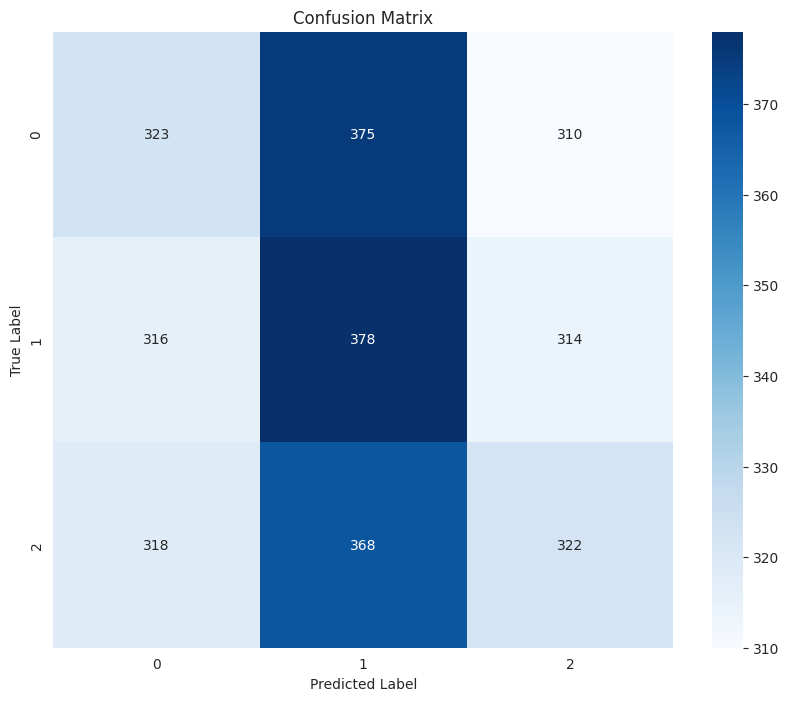

In [32]:
# Generate Precision, Recall and F1-score for the three class problem
conf_matrix = confusion_matrix(train_labels, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=list(train_gen_new.class_indices.keys()),
            yticklabels=list(train_gen_new.class_indices.keys()))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

In [44]:
y_pred = cnn_model.predict(valid_gen_new)
y_true = valid_gen_new.labels
predicted_classes = np.argmax(y_pred, axis=1)

24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 176ms/step


In [45]:
report = classification_report(valid_gen_new.classes, predicted_classes, target_names=list(valid_gen_new.class_indices.keys()))
print(report)

              precision    recall  f1-score   support

           0       0.32      0.29      0.31       126
           1       0.32      0.32      0.32       126
           2       0.38      0.42      0.40       126

    accuracy                           0.34       378
   macro avg       0.34      0.34      0.34       378
weighted avg       0.34      0.34      0.34       378



Text(95.72222222222221, 0.5, 'True Label')

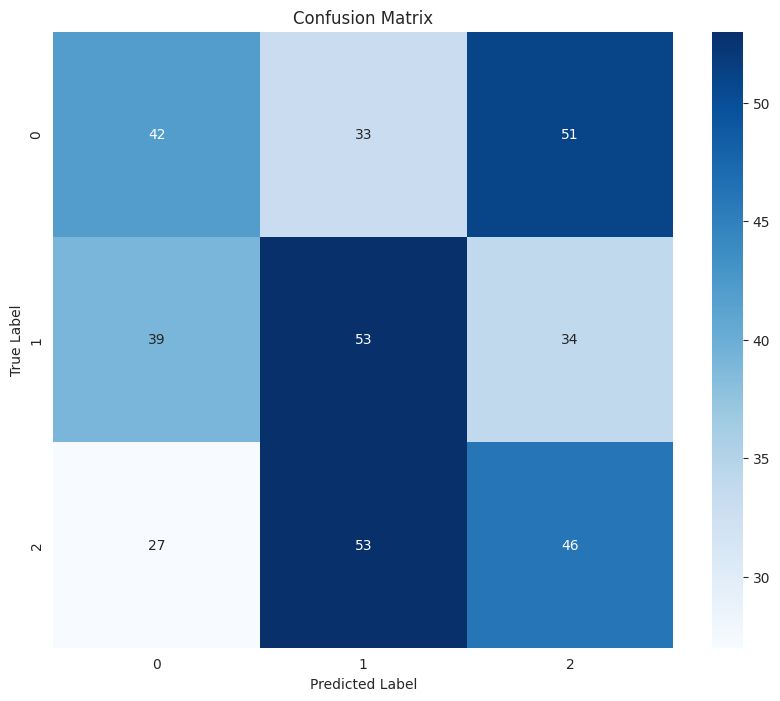

In [35]:
#Confusion Matrix Val Set
conf_matrix = confusion_matrix(valid_gen_new.classes, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=list(valid_gen_new.class_indices.keys()),
            yticklabels=list(valid_gen_new.class_indices.keys()))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

In [ ]:
def ppo_loss(y_true, y_pred):
    epsilon = 0.2
    y_true_one_hot = tf.one_hot(tf.cast(y_true, tf.int32), depth=tf.shape(y_pred)[-1])
    selected_probs = tf.reduce_sum(y_pred * y_true_one_hot, axis=-1)
    old_selected_probs = tf.reduce_sum(tf.stop_gradient(y_pred) * y_true_one_hot, axis=-1)
    ratio = selected_probs / (old_selected_probs + 1e-10)
    clipped_ratio = tf.clip_by_value(ratio, 1 - epsilon, 1 + epsilon)
    loss = -tf.reduce_mean(tf.minimum(ratio, clipped_ratio))
    return loss

In [ ]:
ppo_loss_value = ppo_loss(y_true, y_pred)
print("\nPPO Loss on Validation Data:", ppo_loss_value.numpy())


PPO Loss on Validation Data: -1.0


# TESTING

In [46]:
test_labels = test_gen_new.classes
predictions = cnn_model.predict(test_gen_new)
predicted_classes = np.argmax(predictions, axis=1)

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step


In [47]:
report = classification_report(test_labels, predicted_classes, target_names=list(test_gen_new.class_indices.keys()))
print(report)

              precision    recall  f1-score   support

           0       0.85      0.75      0.80       126
           1       0.74      0.79      0.76       126
           2       0.71      0.75      0.73       126

    accuracy                           0.76       378
   macro avg       0.77      0.76      0.76       378
weighted avg       0.77      0.76      0.76       378



In [ ]:
conf_matrix = confusion_matrix(test_labels, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=list(test_gen_new.class_indices.keys()),
            yticklabels=list(test_gen_new.class_indices.keys()))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')